In [1]:
import pandas as pd
import numpy as np
import re
import lxml

from bs4 import BeautifulSoup
from requests import get

import os
%matplotlib inline

from sklearn.base import BaseEstimator ,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score ,recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [2]:
def Timenow():
    from datetime import datetime
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)

In [180]:
class Basics_genre_expand(BaseEstimator ,TransformerMixin):
    def __init__(self ,Bcutoffpercent=0.01 
                ,path="/Volumes/lin/MachineLearning"
                ,datapath="datasets"
                ,imdb_basics_dtyped=pd.DataFrame([])):
        self.Bcutoffpercent = Bcutoffpercent
        self.imdb_basics_dtyped = imdb_basics_dtyped
        self.path = path
        self.datapath = datapath
    def fit(self ,dfX):
        return self
    
    def transform(self ,dfX):
        '''try:
            dfY = basics[ratings.index.notnull()]
            basics ,basicscols = Basics_genre_expand(dfY)
            dfY = Genre_1hot(basics ,basicscols ,'genres')
        except:
            print('WENT TO EXCEPT 1')
            basics ,basicscols = Basics_genre_expand(dfX)
            dfY = Genre_1hot(basics ,basicscols ,'genres')'''
        basics ,basicscols = self.__Expand(dfX)
        dfY = self.__Genre_bool(basics ,basicscols ,'genres')
        basicscols2 = ['titleType','startYear','endYear','runtimeMinutes']
        return dfX[basicscols2].join(dfY ,how='inner')
    
    #dtyped basics dataframe
    def Basics_dtype(self):
        if self.imdb_basics_dtyped.shape==(0,0):
            imdb_basics_raw=pd.read_csv(os.path.join(self.path,self.datapath,"imdb/title.basics.tsv/title.basics.tsv"), sep='\t', header=0
                ,index_col='tconst'
            )

            imdb_basics_raw[['runtimeMinutes','startYear','endYear']] \
                = imdb_basics_raw[['runtimeMinutes','startYear','endYear']].apply(lambda x: \
                    np.where((x=='\\N') | ~x.astype('str').str.isalnum() ,'0' ,x) \
                    ,axis=0)
            col_basics={'titleType':'category','primaryTitle':'object','originalTitle':'object' \
                 ,'isAdult':'bool','startYear':'int64','endYear':'int64' \
                 ,'runtimeMinutes':'int64','genres':'object'}
            self.imdb_basics_dtyped = imdb_basics_raw.astype(col_basics)
            imdb_basics_cols = ['titleType','primaryTitle' \
                                ,'startYear','endYear','runtimeMinutes','genres']
            self.imdb_basics_dtyped = self.imdb_basics_dtyped[imdb_basics_cols]
            self.imdb_basics_dtyped = self.imdb_basics_dtyped.loc[ \
                self.imdb_basics_dtyped['titleType']!='tvEpisode']
            
        return self.imdb_basics_dtyped

    def __Expand(self ,dfX):
        df07 = pd.DataFrame(dfX['genres'].str.split(',',expand=True)) \
            .rename(columns=lambda x: x+1).add_prefix('genre')

        df08 = df07.stack().reset_index()[0]
        df0freq = df08.value_counts()
        cutoff = int(sum(df0freq)*self.Bcutoffpercent)
        df0infreq = df0freq[df0freq<cutoff].index
        df08.replace(df0infreq ,'Other' ,inplace=True)
        #df010 = df08.replace(df0infreq+['\\N'] ,'Other')
        df011 = list(df08.unique())
        df0col = pd.DataFrame(columns=df011).astype('bool')

        dfX['genres'].replace(df0infreq ,'Other' ,inplace=True)
        df01concat = [dfX ,df0col]
        df01uniq = pd.concat(df01concat ,axis=1)

        return df01uniq ,df011
    
    #fills in expanded columns
    def __Genre_bool(self ,dfX ,dfXcol ,col):
        df1 = dfX.apply(lambda x: self.__Match_genre(dfX ,x ,dfXcol ,col)
                           if x.name in dfXcol else x
                           ,axis='index'
        #                  ,result_type='reduce')
                                 )
        #    col_dtypes = {'region':'list','language':'list'}
        #    df01hot = df01hot.astype(col_dtypes)
        return df1[dfXcol]
    
    #exclusively called by Genre_bool
    def __Match_genre(self ,dfX ,x ,Xcol ,col): #axis=index
        colname = x.name
        i = list(dfX.index)
        colval = dfX[col].loc[i]
        return colval.apply(lambda f: colname in f)


#used to filter dataset based on netflix statistics in order to reduce imdb dataset 
#to only higher # of votes where netflix data is applicable. 
#goal to target only most popular titles
class Netflix(Basics_genre_expand):
    def __init__(self):
        Basics_genre_expand.__init__(self)
    
    #exclusively called by Netflix_uniq0() ,Netflix_uniq1()
    def _Netflix_titles(self):
        netflix = pd.read_csv(os.path.join(self.path,self.datapath,"netflix_titles.csv"))
        netflix_uniqueTitles = pd.DataFrame(netflix.title.unique() ,columns=['title'])
        netflix_uniqueTitles.set_index(keys=['title'] ,inplace=True)
        return netflix_uniqueTitles
    
    #returns only index column
    def Netflix_uniq0(self ,dfX ,colX):
        netflix_uniqueTitles = self._Netflix_titles()

        indX = dfX.index.name
        dfX.reset_index(inplace=True)
        dfX.set_index(keys=colX ,inplace=True)
        dfX_titles = dfX.join(netflix_uniqueTitles ,how='inner')
        #dfX_titles.reset_index(inplace=True)
        dfX_uniq = dfX_titles[indX].unique()
        dfX_uniq2 = pd.DataFrame(dfX_uniq ,columns=[indX]) 
        dfX_uniq2.set_index(keys=indX ,inplace=True ,drop=True)

        return dfX_uniq2

    #exclusively called by NetflixStats()
    #returns dfX but filtered by netflix
    def Netflix_uniq1(self ,dfX):
        indX = dfX.index.name

        '''try:
            imdb_basics = basics.reindex(ratings.index)
        except:
            print('WENT TO EXCEPT 2')
            imdb_basics = basics_dtype'''
        
        basics_netflix_uniq = self.Netflix_uniq0(self.Basics_dtype() ,'primaryTitle') 
        
        #return dfX.reindex(basics_netflix_uniq.index ,copy=False)
        return dfX.join(basics_netflix_uniq ,how='inner')


class Ratings_expand(Netflix ,Basics_genre_expand):
    def __init__(self ,imdb_ratings_filtered=pd.DataFrame([])):
        self.imdb_ratings_filtered=imdb_ratings_filtered
        Basics_genre_expand.__init__(self)
        
    def fit(self ,dfX):
        return self
    
    def transform(self ,dfX):
        return self.__Ratings_expand(self.__Ratings_netflix_filter(dfX))

    #dtyped ratings dataframe
    def Ratings_dtype(self):
        ratings = pd.read_csv(os.path.join(self.path,self.datapath,"imdb/title.ratings.tsv/title.ratings.tsv"), sep='\t', header=0
            ,index_col=['tconst']
            ,dtype={'averageRating':'float64','numVotes':'float64'}
         )
        return ratings
    
    def __Ratings_netflix_filter(self ,dfX): 
        '''if self.ratings.shape==(0,0):'''
        ratings_netflix_uniq = self.Netflix_uniq1(dfX)
        netflix_stats = pd.concat([ratings_netflix_uniq.mean()] 
                                  + [ratings_netflix_uniq.std()])

        self.imdb_ratings_filtered = dfX.loc[dfX.numVotes 
                                        > netflix_stats[1] - 0.0*netflix_stats[3]]

        return self.imdb_ratings_filtered
        '''else:
            dfX_filtered = dfX.loc[self.ratings.index]

            return dfX_filtered'''

    #feature expansion
    def __Ratings_expand(self ,dfX):
        rate_stats = pd.concat([dfX.mean()] + [dfX.std()])

        dfX.loc[:,'ratecat'] \
            = dfX[['averageRating']].apply(lambda x: \
                sum([(x>rate_stats[0] - 2.0*rate_stats[2]) \
                    ,(x>rate_stats[0] - rate_stats[2]) \
                    ,(x>rate_stats[0]) \
                    ,(x>rate_stats[0] + rate_stats[2]) \
                    ,(x>rate_stats[0] + 2.0*rate_stats[2])] \
                ) \
             ).astype('float64')
        dfX.loc[:,'votecat'] \
            = dfX[['numVotes']].apply(lambda x: \
                sum([(x>rate_stats[1] - 2.0*rate_stats[3]) \
                    ,(x>rate_stats[1] - rate_stats[3]) \
                    ,(x>rate_stats[1]) \
                    ,(x>rate_stats[1] + rate_stats[3]) \
                    ,(x>rate_stats[1] + 2.0*rate_stats[3])] \
                ) \
             ).astype('float64')
        dfX.loc[:,'score'] \
            = dfX['ratecat'] + dfX['votecat']

        rate_dtype = {'numVotes':'int64','ratecat':'int64' ,'votecat':'int64' 
                      ,'score':'int64'}
        
        return dfX.astype(rate_dtype)
    

class Regions_expand(Ratings_expand):
    def __init__(self ,Rcutoffpercent=.01):
        self.Rcutoffpercent = Rcutoffpercent
        Basics_genre_expand.__init__(self)
    
    def fit(self ,dfX):
        return self
    
    def transform(self ,dfX ,dfY):
        regions ,regionsscols = self.__Regions_expand(dfX ,dfY)
        dfY = self.__Region_bool(regions ,regionsscols ,'region')
    
        return dfY[regionsscols]
        #return dfX.join(dfY ,how='inner')
      
    #dtyped region dataframe
    def Akas_dtype(self):
        imdb_akas=pd.read_csv(os.path.join(self.path,self.datapath,"imdb/title.akas.tsv/title.akas.tsv") , sep='\t', header=0 
            ,index_col='titleId'
            ,dtype={'ordering':'int64','title':'object','region':'str'
                   ,'language':'str','types':'category','attirbutes':'object','isOrignalTitle':'bool'}
        )
        imdb_akas_cols = ['region']
        return imdb_akas[imdb_akas_cols]

    #feature expansion
    def __Region_count(self ,dfX):
        df01 = dfX.groupby(dfX.index)
        df02 = pd.DataFrame(df01.agg(list))
        df02['regioncount'] = df02['region'].apply(len)

        return df02
        #245 values imdb_akas_movies.region.value_counts()
        #102 values imdb_akas_movies.language.value_counts() can ignore this
            #, since region has more values
            
    #feature expansion
    def __Regions_expand(self ,dfX ,dfY):
        #cols_1hot

        akas_filtered = dfX.join(dfY.drop( \
            columns=dfY.columns ,inplace=False) ,how='inner')
        region_counts = self.__Region_count(akas_filtered)
        cols = []
        num = '{x:n}'
        for x in range(0 ,region_counts.region.str.len().max()):
            cols.append('region'+ num.format(x=x))

        df07 = pd.DataFrame(region_counts.region.tolist() ,columns=cols  
                            ,index=[region_counts.index])
        df08 = df07.stack().reset_index()[0]
        #df09 = df08.loc[df08!='\\N']
        df09 = df08
        df0freq = df09.value_counts()
        #print(df0freq ,'\n' ,type(df0freq))
        cutoff = int(sum(df0freq)*self.Rcutoffpercent)
        df0infreq = df0freq[df0freq<cutoff].index
        df09.replace(df0infreq ,'Other' ,inplace=True) 
        df011 = list(df09.unique())
        df0col = pd.DataFrame(columns=df011).astype('bool')

        region_counts['region'].replace(df0infreq ,'Other' ,inplace=True)
        df01concat = [region_counts ,df0col]

        df01uniq = pd.concat(df01concat ,axis=1)

        return df01uniq ,df011
    
    #fills in expand regions
    def __Region_bool(self ,dfX ,dfXcol ,col):
        return dfX.apply(lambda x: self.__Match_region(dfX ,x ,dfXcol ,col)
                           if x.name in dfXcol else x
                           ,axis='index')
    
    #exclusivley called by Region_1hot
    def __Match_region(self ,dfX ,x ,Xcol ,col): #axis=index
        colname = x.name
        i = list(dfX.index)
        colval = dfX[col].loc[i]
        return colval.apply(lambda f: colname in f)
    
    
def Combine(cutoffpercent=0.1):
    basics_expand = Basics_genre_expand()
    ratings_expand = Ratings_expand()
    regions_expand = Regions_expand()
    
    basics_dtype = basics_expand.Basics_dtype()
    basics_cols = ['titleType' ,'startYear','endYear','runtimeMinutes','genres']
    
    ratings_dtype = ratings_expand.Ratings_dtype()
    ratings_cols = ['averageRating','numVotes']
    
    akas_dtyped = regions_expand.Akas_dtype()
    akas_columns = ['region']
    
    Timenow()
    basics = basics_expand.transform(basics_dtype[basics_cols])
    ratings = ratings_expand.transform(ratings_dtype[ratings_cols])
    regions = regions_expand.transform(akas_dtyped[akas_columns] ,ratings_dtype)
    
    df0freq = basics['titleType'].value_counts()
    cutoff = int(sum(df0freq)*cutoffpercent)
    df0infreq = df0freq[df0freq<cutoff].index
    basics['titleType'].replace(df0infreq ,'Other' ,inplace=True)
    basics[['titleType']] = basics[['titleType']].astype({'titleType':'category'})
    D = basics.join(ratings ,how='inner' ,rsuffix='_rating')
    Timenow()
    
    return D.join(regions ,how='inner' ,rsuffix='_region')

In [8]:
Timenow()
combined = Combine()
Timenow()
combined

Current Time = 20:10:13


/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Current Time = 20:11:23


/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/pandas/core/generic.py:6788: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/ipykernel_launcher.py:144: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning

Current Time = 20:16:28
Current Time = 20:16:28


,titleType,startYear,endYear,runtimeMinutes,Documentary,Short,Animation,Comedy,Romance,Other,...,BR,XWW,TR,DK,SE,MX,JP,CA,IN,XWG
tt0000417,short,1902,0,13,False,False,False,True,False,False,...,True,True,False,True,True,True,True,False,False,False
tt0000439,short,1903,0,11,False,True,False,False,False,False,...,True,False,False,True,True,False,True,True,False,False
tt0004972,movie,1915,0,195,False,False,False,False,False,False,...,True,True,True,True,True,True,True,False,False,False
tt0006864,movie,1916,0,163,False,False,False,False,False,False,...,True,False,False,True,True,True,False,False,False,False
tt0010323,movie,1920,0,76,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,False,False
tt0012349,movie,1921,0,68,False,False,False,True,False,False,...,True,False,True,True,True,True,False,True,False,False
tt0013442,movie,1922,0,94,False,False,False,False,False,False,...,True,True,False,False,True,True,False,True,False,False
tt0014429,movie,1923,0,74,False,False,False,True,False,False,...,True,False,False,True,True,False,False,False,False,False
tt0015324,movie,1924,0,45,False,False,False,True,True,False,...,True,False,False,True,True,False,True,False,True,False
tt0015648,movie,1925,0,75,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,False


In [176]:
def split_train_test_validation(data ,test_ratio ,validation_ratio):
    shuffled_ind = np.random.permutation(len(data))
    
    validation_size = int(len(data)*validation_ratio)
    validation_ind = shuffled_ind[:validation_size]
    
    test_size = int(len(data)*test_ratio)
    test_ind = shuffled_ind[validation_size:test_size]
    train_ind = shuffled_ind[validation_size+test_size:]
    
    return data.iloc[validation_ind] ,data.iloc[test_ind] ,data.iloc[train_ind]


validation_set ,test_set ,train_set = split_train_test_validation(combined ,0.2 ,0.1)


def Train_class():
    netflix_ind = Netflix().Netflix_uniq1(train_set)
    classifier = train_set.join(netflix_ind ,how='left' ,rsuffix='_netflix')
    
    return (classifier['titleType']==classifier['titleType_netflix'])


def Test_class():
    netflix_ind = Netflix().Netflix_uniq1(test_set)
    classifier = test_set.join(netflix_ind ,how='left' ,rsuffix='_netflix')
    
    return (classifier['titleType']==classifier['titleType_netflix'])


def Validation_class():
    netflix_ind = Netflix().Netflix_uniq1(validation_set)
    classifier = validation_set.join(netflix_ind ,how='left' ,rsuffix='_netflix')
    
    return (classifier['titleType']==classifier['titleType_netflix'])


def Full_class(dfX):
    netflix_ind = Netflix().Netflix_uniq1(dfX)
    classifier = dfX.join(netflix_ind ,how='left' ,rsuffix='_netflix')
    
    return (classifier['titleType']==classifier['titleType_netflix'])

In [10]:
train_set.shape

(5285, 54)

In [20]:
y_train = Train_class()
y_test = Test_class()
y_validation = Validation_class()

/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  
/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
y_train.shape

(5285,)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print (combined.dtypes)

In [46]:
#first run
#nums = ['startYear','endYear','runtimeMinutes','numVotes','ratecat','votecat','score']
#cats = list(train_set.drop(labels=nums ,axis='columns').columns)

#feature importance selection
nums = ['startYear','numVotes','ratecat','votecat','score']
cats = ['titleType']
allcols = nums+cats

  
full_pipeline = ColumnTransformer([
    ('stdscaler' ,StandardScaler() ,nums)
    ,('pca' ,PCA(n_components=0.95) ,nums)
    ,('cat' ,OneHotEncoder() ,cats)
])

x_train = full_pipeline.fit_transform(train_set)
x_test = full_pipeline.fit_transform(test_set)

In [49]:
x_train.shape

(5285, 10)

In [55]:
from sklearn.ensemble import GradientBoostingClassifier()
from sklearn.metrics import mean_squared_error

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [122]:
gbrc = GradientBoostingClassifier()
y_cross_val_predict = cross_val_predict(gbrc ,x_train ,y_train ,cv=3)

In [60]:
confusion_matrix(y_train ,y_cross_val_predict)

array([[4430,   49],
       [ 767,   39]])

In [61]:
from sklearn.metrics import precision_recall_curve

In [62]:
def plot_precision_recall_v_threshold(precisions ,recalls ,thresholds):
    plt.plot(thresholds ,precisions[:-1] ,'b--' ,label="Precision")
    plt.plot(thresholds ,recalls[:-1] ,'g-' ,label='Recall')
    plt.xlabel('threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])

In [64]:
y_scores = cross_val_predict(gbrt ,x_train ,y_train ,cv=3 ,method='decision_function')

In [65]:
precisions ,recalls ,thresholds = precision_recall_curve(y_train ,y_scores)

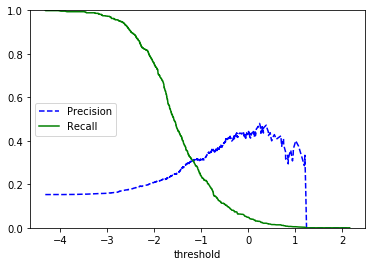

In [66]:
plot_precision_recall_v_threshold(precisions ,recalls ,thresholds)
plt.show()

In [67]:
from sklearn.metrics import roc_curve

In [68]:
def plot_roc_curve(fpr ,tpr ,label=None):
    plt.plot(fpr ,tpr ,linewidth=2 ,label=label)
    plt.plot([0,1] ,[0,1] ,'k--')
    plt.axis([0 ,1 ,0 ,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [71]:
fpr ,tpr ,thresholds = roc_curve(y_train ,y_scores)

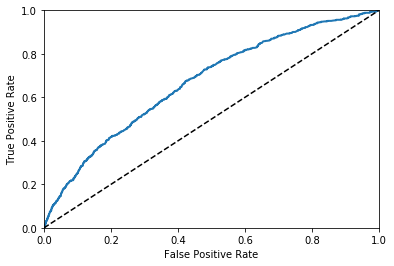

In [72]:
plot_roc_curve(fpr ,tpr)
plt.show()

In [137]:
y_scores_thresh = (y_scores > -3.3)
confusion_matrix(y_train ,y_scores_thresh)

array([[ 174, 4305],
       [   9,  797]])

In [192]:
full_class = Full_class(combined)

/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [185]:
fullT = full_pipeline.transform(combined)
y_scores_full = cross_val_predict(gbrt ,fullT ,full_class ,cv=3 ,method='decision_function')

In [193]:
y_scores_full_thres = (y_scores_full>-3.3)
confusion_matrix(full_class ,y_scores_full_thres)

array([[2298, 4108],
       [ 422,  720]])

In [ ]:
#CONCLUSION: gbrc model selected did not generalize well

In [ ]:
#below is determining best model using grid search

In [79]:
from sklearn.model_selection import GridSearchCV

In [124]:
Timenow()
param_grid = [
    { 'n_estimators': [13 ,17], 'max_features': [10,9] ,'learning_rate':[.2]},
]

#forest_reg = RandomForestRegressor()
grid_searchG = GridSearchCV(gbrc, param_grid, cv=3,
                          scoring = 'precision',
                          return_train_score = True)
grid_searchG.fit(x_train, y_train)
Timenow()

Current Time = 21:04:57
Current Time = 21:04:58


In [125]:
gbrcB = grid_searchG.best_estimator_
y_cross_val_predictB = cross_val_predict(gbrc ,x_train ,y_train ,cv=3)

In [126]:
confusion_matrix(y_train ,y_cross_val_predictB)

array([[4430,   49],
       [ 767,   39]])

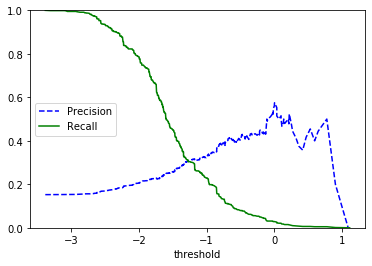

In [128]:
y_scoresB = cross_val_predict(gbrcB ,x_train ,y_train ,cv=3 ,method='decision_function')
precisionsB ,recallsB ,thresholdsB = precision_recall_curve(y_train ,y_scoresB)
plot_precision_recall_v_threshold(precisionsB ,recallsB ,thresholdsB)
plt.show()

In [203]:
#best model and threshold selection yield similar results
#CONCLUSION: titleType feature is more important than ratings, which is suspect
feature_importancesG = grid_searchG.best_estimator_.feature_importances_
cat_encoder = full_pipeline.named_transformers_['cat']
cat_encoder_cols = list(cat_encoder.categories_[0])
attributes = cat_encoder_cols + nums 
sorted(zip(feature_importancesG ,attributes) ,reverse=True)

[(0.4067534627444733, 'Other'),
 (0.29292300850127384, 'movie'),
 (0.15346560910463403, 'numVotes'),
 (0.08751705929597935, 'ratecat'),
 (0.025203887823864998, 'short'),
 (0.01575059178569543, 'votecat'),
 (0.010947677444726208, 'startYear'),
 (0.007438703299352913, 'video'),
 (0.0, 'score')]

In [ ]:
#all below code is extra code that was investigating best model

In [23]:
sgd_clf = SGDClassifier()
sgd_clf.fit(x_data ,y_netflix)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
y_netflix_predict = cross_val_predict(sgd_clf ,x_data ,y_netflix ,cv=3)

In [25]:
confusion_matrix(y_netflix ,y_netflix_predict)

array([[1861, 2635],
       [ 357,  432]])

In [26]:
precision_score(y_netflix ,y_netflix_predict)

0.14085425497228563

In [27]:
recall_score(y_netflix ,y_netflix_predict)

0.5475285171102662

In [28]:
f1_score(y_netflix ,y_netflix_predict)

0.22406639004149376

In [29]:
y_scores = cross_val_predict(sgd_clf ,x_data ,y_netflix ,cv=3 ,method='decision_function')

In [30]:
from sklearn.metrics import precision_recall_curve

In [31]:
precisions ,recalls ,thresholds = precision_recall_curve(y_netflix ,y_scores)

In [32]:
precisions

array([0.14951677, 0.14935557, 0.14938389, ..., 0.5       , 0.        ,
       1.        ])

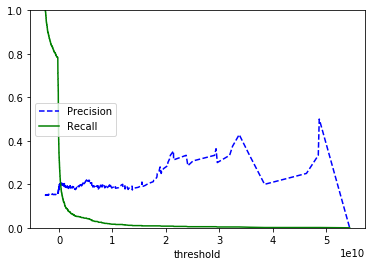

In [34]:
plot_precision_recall_v_threshold(precisions ,recalls ,thresholds)
plt.show()

In [35]:
from sklearn.metrics import roc_curve

In [36]:
def plot_roc_curve(fpr ,tpr ,label=None):
    plt.plot(fpr ,tpr ,linewidth=2 ,label=label)
    plt.plot([0,1] ,[0,1] ,'k--')
    plt.axis([0 ,1 ,0 ,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [37]:
fpr ,tpr ,thresholds = roc_curve(y_netflix ,y_scores)

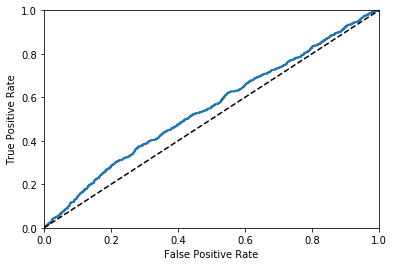

In [38]:
plot_roc_curve(fpr ,tpr)
plt.show()

In [196]:
from sklearn.ensemble import RandomForestClassifier

In [199]:
forest_clf = RandomForestClassifier(random_state=42)

In [40]:
y_probas_forest = cross_val_predict(forest_clf ,x_data ,y_netflix
                                    ,cv=3 ,method='predict_proba')

/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [235]:
forest_clf_best = grid_searchF.best_estimator_
y_probas_forestbest = cross_val_predict(forest_clf ,x_data ,y_netflix
                                    ,cv=3 ,method='predict_proba')

/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [41]:
y_netflix_predictF = cross_val_predict(forest_clf ,x_data ,y_netflix ,cv=3)

/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [230]:
y_netflix_predictFbest = cross_val_predict(forest_clf_best ,x_data ,y_netflix ,cv=3)

In [42]:
confusion_matrix(y_netflix ,y_netflix_predictF)

array([[4236,  260],
       [ 688,  101]])

In [228]:
confusion_matrix(y_netflix ,y_netflix_predictFbest)

array([[3994,  506],
       [ 585,  200]])

In [43]:
precision_score(y_netflix ,y_netflix_predictF)

0.27977839335180055

In [44]:
precision_score(y_netflix ,y_netflix_predictFbest)

NameError: name 'y_netflix_predictFbest' is not defined

In [45]:
recall_score(y_netflix ,y_netflix_predictF)

0.12801013941698353

In [232]:
recall_score(y_netflix ,y_netflix_predictFbest)

0.25477707006369427

In [46]:
f1_score(y_netflix ,y_netflix_predictF)

0.1756521739130435

In [233]:
f1_score(y_netflix ,y_netflix_predictFbest)

0.26827632461435275

In [47]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest ,tpr_forest ,thresholds_forest = roc_curve(y_netflix ,y_scores_forest)

In [241]:
y_scores_forestB = y_probas_forestbest[:,1]
fpr_forestB ,tpr_forestB ,thresholds_forestB = roc_curve(y_netflix ,y_netflix_predictFbest)

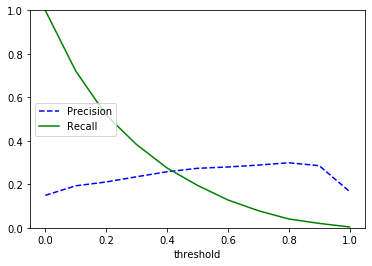

In [48]:
precisionsF ,recallsF ,thresholdsF = precision_recall_curve(y_netflix ,y_scores_forest)
plot_precision_recall_v_threshold(precisionsF ,recallsF ,thresholdsF)
plt.show()

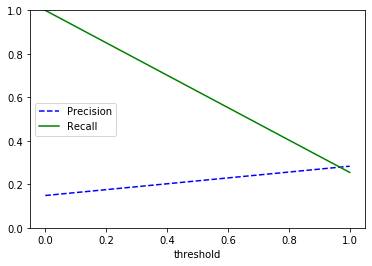

In [238]:
precisionsFB ,recallsFB ,thresholdsFB = precision_recall_curve(y_netflix ,y_netflix_predictFbest)
plot_precision_recall_v_threshold(precisionsFB ,recallsFB ,thresholdsFB)
plt.show()

In [49]:
def plot_precision_recall(precision ,recall ,label=None):
    plt.plot(recall ,precision ,linewidth=2 ,label=label)
    plt.axis([0 ,1 ,0 ,1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')

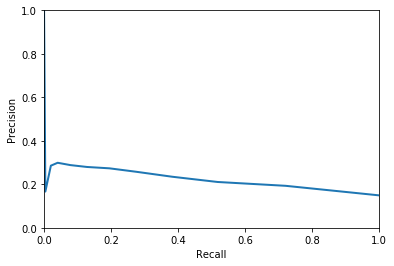

In [50]:
plot_precision_recall(precisionsF ,recallsF)
plt.show()

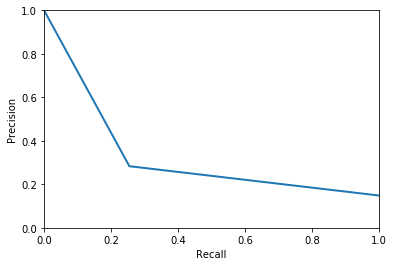

In [239]:
plot_precision_recall(precisionsFB ,recallsFB)
plt.show()

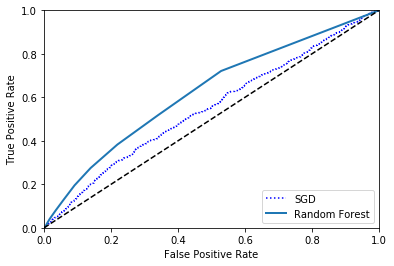

In [51]:
plt.plot(fpr ,tpr ,'b:' ,label='SGD')
plot_roc_curve(fpr_forest ,tpr_forest ,'Random Forest')
plt.legend(loc='lower right')
plt.show()

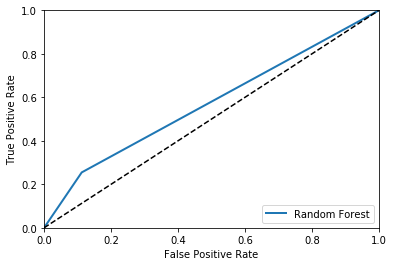

In [245]:
plot_roc_curve(fpr_forestB ,tpr_forestB ,'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [198]:
y_scores_pt7 = (y_netflix_predictF > .02)
precision_score(y_netflix ,y_scores_pt7)

0.5230769230769231

In [132]:
plt.plot(precision ,recall ,'g:' ,label='SGD')
plot_roc_curve(fpr_forest ,tpr_forest ,'Random Forest')
plt.legend(loc='lower right')
plt.show()

(5285, 2)

In [200]:
Timenow()
param_grid = [
  #  {'n_estimators': [50 ,100], 'max_features': [635 ,636]},
    {'bootstrap': [False], 'n_estimators': [100,200], 'max_features': [1 ,2] ,'random_state':[42]},
]
#forest_reg = RandomForestRegressor()
grid_searchF = GridSearchCV(forest_clf, param_grid, cv=4,
                          scoring = 'precision',
                          return_train_score = True)
grid_searchF.fit(x_data, y_netflix)
Timenow()

Current Time = 21:55:19
Current Time = 21:55:40


In [56]:
grid_searchF.best_params_

{'bootstrap': False, 'max_features': 3, 'n_estimators': 77, 'random_state': 42}

In [201]:
grid_searchF.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [202]:
#CONCLUSION: very few of the features are meaningful. 
#Dataset features are insignificant. Low performance measure scores.
feature_importances = grid_searchF.best_estimator_.feature_importances_
cat_encoder = full_pipeline.named_transformers_['cat']
cat_encoder_cols = list(cat_encoder.categories_[0])
attributes = cat_encoder_cols + nums 
sorted(zip(feature_importances ,attributes) ,reverse=True)

[(0.38172349242160264, 'numVotes'),
 (0.37995379325716483, 'movie'),
 (0.2118337196629235, 'Other'),
 (0.010832781139652145, 'startYear'),
 (0.009773847356419908, 'short'),
 (0.0025065595494792987, 'video'),
 (0.001203667457013493, 'ratecat'),
 (0.0011496572393254845, 'votecat'),
 (0.00046897744078132895, 'score')]

In [ ]:
'''split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(combin
                                           ed, combined[['titleType']]):                               
    strat_train_set = data_sorted.iloc[train_index]
    strat_test_set = data_sorted.iloc[test_index]'''

In [ ]:
'''base_pipeline = ColumnTransformer([
    ('genresB' ,Basics_genre_expand() ,basics_cols)
    ,('ratingsB' ,Ratings_expand() ,ratings_cols)
    ,('regionsB' ,Regions_expand() ,akas_columns)
])

combined = base_pipeline.fit_transform(combined)
Timenow()'''